# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

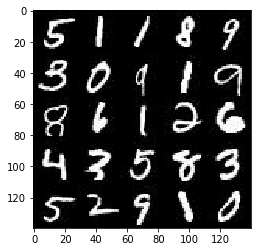

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

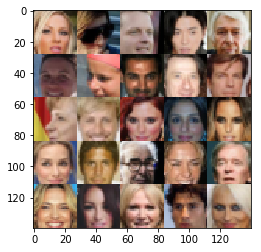

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate',shape=())
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    def lrelu(x, leak=0.2):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return (f1 * x + f2 * abs(x))
    
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images, 64,5,strides=2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        relu1 = lrelu(x1)
        
        x2 = tf.layers.conv2d(relu1, 128,5,strides=2,padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = lrelu(bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = lrelu(bn3)
        
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [66]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    def lrelu(x, leak=0.2):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return (f1 * x + f2 * abs(x))
        
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2 * 2 * 1024, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = lrelu(x1)
        # 2x2x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2)
        # 4x4x512
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=1, padding='valid',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(x3)
        # 7x7x256
        
        x31 = tf.layers.conv2d_transpose(x3, 256, 1, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x31 = tf.layers.batch_normalization(x31, training=is_train)
        x31 = lrelu(x31)
        # 7x7x256
        
        x4 = tf.layers.conv2d_transpose(x31, 128, 4, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = lrelu(x4)
        # 14x14x128
        
        x5 = tf.layers.conv2d_transpose(x4, 128, 1, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = lrelu(x5)
        # 14x14x128
          
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        # 28x28xout_channel_dim
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [67]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [68]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [69]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [70]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sampels, losses = [],[]
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #batch_images = batch_images * 2
                steps += 1
                
                # Real image input for discriminator
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2],data_shape[3])
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count), 
                           "Discriminator Loss: {:4f}...".format(train_loss_d),
                           "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after trainig
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3],data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.596719... Generator Loss: 0.4854
Epoch 1/2... Discriminator Loss: 2.656861... Generator Loss: 13.8625
Epoch 1/2... Discriminator Loss: 3.942711... Generator Loss: 0.1212
Epoch 1/2... Discriminator Loss: 1.607721... Generator Loss: 0.4519
Epoch 1/2... Discriminator Loss: 1.457160... Generator Loss: 0.4115
Epoch 1/2... Discriminator Loss: 1.916593... Generator Loss: 0.3459
Epoch 1/2... Discriminator Loss: 0.796107... Generator Loss: 1.2128
Epoch 1/2... Discriminator Loss: 0.826962... Generator Loss: 1.5560
Epoch 1/2... Discriminator Loss: 1.541687... Generator Loss: 6.4916
Epoch 1/2... Discriminator Loss: 1.281252... Generator Loss: 0.7029


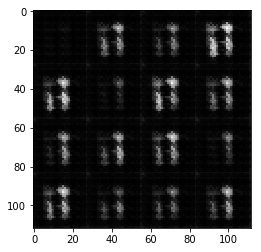

Epoch 1/2... Discriminator Loss: 0.800410... Generator Loss: 1.2749
Epoch 1/2... Discriminator Loss: 0.962279... Generator Loss: 2.4783
Epoch 1/2... Discriminator Loss: 0.680851... Generator Loss: 2.2893
Epoch 1/2... Discriminator Loss: 0.792478... Generator Loss: 2.0229
Epoch 1/2... Discriminator Loss: 0.885508... Generator Loss: 1.2479
Epoch 1/2... Discriminator Loss: 1.694504... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 1.160757... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.660893... Generator Loss: 0.4526
Epoch 1/2... Discriminator Loss: 1.413128... Generator Loss: 0.5391
Epoch 1/2... Discriminator Loss: 1.438267... Generator Loss: 0.6935


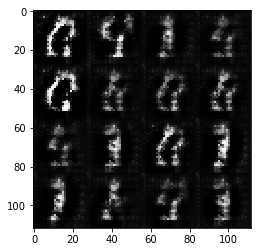

Epoch 1/2... Discriminator Loss: 1.491782... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 1.672151... Generator Loss: 0.4988
Epoch 1/2... Discriminator Loss: 1.630044... Generator Loss: 0.5115
Epoch 1/2... Discriminator Loss: 1.513645... Generator Loss: 0.4473
Epoch 1/2... Discriminator Loss: 1.262889... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.697538... Generator Loss: 0.7265
Epoch 1/2... Discriminator Loss: 1.206807... Generator Loss: 1.4336
Epoch 1/2... Discriminator Loss: 1.479681... Generator Loss: 1.4998
Epoch 1/2... Discriminator Loss: 1.135493... Generator Loss: 1.2044
Epoch 1/2... Discriminator Loss: 1.351428... Generator Loss: 1.2839


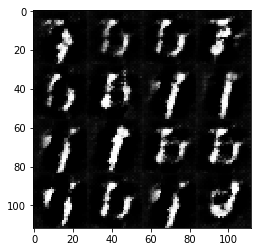

Epoch 1/2... Discriminator Loss: 1.504989... Generator Loss: 1.5628
Epoch 1/2... Discriminator Loss: 1.190387... Generator Loss: 1.4199
Epoch 1/2... Discriminator Loss: 1.323848... Generator Loss: 1.8225
Epoch 1/2... Discriminator Loss: 1.366110... Generator Loss: 1.5512
Epoch 1/2... Discriminator Loss: 1.421504... Generator Loss: 2.0016
Epoch 1/2... Discriminator Loss: 1.361295... Generator Loss: 1.1030
Epoch 1/2... Discriminator Loss: 1.025785... Generator Loss: 1.3064
Epoch 1/2... Discriminator Loss: 1.475997... Generator Loss: 1.9101
Epoch 1/2... Discriminator Loss: 1.183349... Generator Loss: 1.5173
Epoch 1/2... Discriminator Loss: 1.231796... Generator Loss: 2.1071


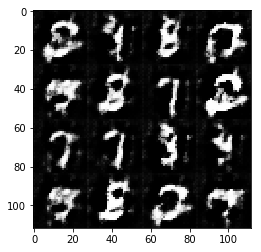

Epoch 1/2... Discriminator Loss: 1.115711... Generator Loss: 1.1805
Epoch 1/2... Discriminator Loss: 1.538507... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 1.527849... Generator Loss: 0.4320
Epoch 1/2... Discriminator Loss: 1.453514... Generator Loss: 0.4825
Epoch 1/2... Discriminator Loss: 1.251801... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 1.359078... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 1.375206... Generator Loss: 0.5903
Epoch 1/2... Discriminator Loss: 1.444248... Generator Loss: 0.4950
Epoch 1/2... Discriminator Loss: 1.396245... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 1.383747... Generator Loss: 0.6693


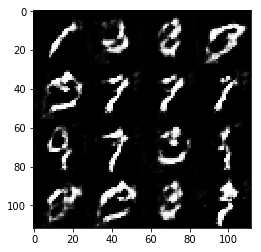

Epoch 1/2... Discriminator Loss: 1.332456... Generator Loss: 1.3717
Epoch 1/2... Discriminator Loss: 1.338017... Generator Loss: 1.4882
Epoch 1/2... Discriminator Loss: 1.183614... Generator Loss: 0.9025
Epoch 1/2... Discriminator Loss: 1.493149... Generator Loss: 1.6657
Epoch 1/2... Discriminator Loss: 1.105902... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.374798... Generator Loss: 0.5668
Epoch 1/2... Discriminator Loss: 1.251529... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.151278... Generator Loss: 0.8593
Epoch 1/2... Discriminator Loss: 1.380268... Generator Loss: 1.8784
Epoch 1/2... Discriminator Loss: 1.588199... Generator Loss: 1.4396


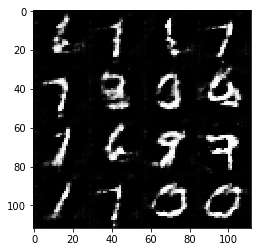

Epoch 1/2... Discriminator Loss: 1.458062... Generator Loss: 1.2049
Epoch 1/2... Discriminator Loss: 1.391278... Generator Loss: 1.2129
Epoch 1/2... Discriminator Loss: 1.205484... Generator Loss: 1.1497
Epoch 1/2... Discriminator Loss: 1.269184... Generator Loss: 0.9906
Epoch 1/2... Discriminator Loss: 1.182642... Generator Loss: 1.1949
Epoch 1/2... Discriminator Loss: 1.382372... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 1.485614... Generator Loss: 0.5077
Epoch 1/2... Discriminator Loss: 1.257915... Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 1.248852... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 1.504681... Generator Loss: 1.5642


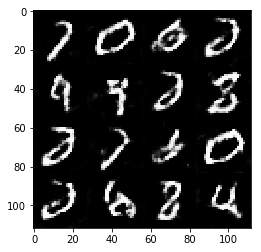

Epoch 1/2... Discriminator Loss: 1.254338... Generator Loss: 1.2045
Epoch 1/2... Discriminator Loss: 1.358717... Generator Loss: 1.2025
Epoch 1/2... Discriminator Loss: 1.430448... Generator Loss: 1.4665
Epoch 1/2... Discriminator Loss: 1.362709... Generator Loss: 1.3632
Epoch 1/2... Discriminator Loss: 1.249335... Generator Loss: 1.0681
Epoch 1/2... Discriminator Loss: 1.272409... Generator Loss: 1.3798
Epoch 1/2... Discriminator Loss: 1.443136... Generator Loss: 1.2557
Epoch 1/2... Discriminator Loss: 1.224947... Generator Loss: 1.1810
Epoch 1/2... Discriminator Loss: 1.379542... Generator Loss: 1.1712
Epoch 1/2... Discriminator Loss: 1.230731... Generator Loss: 1.2926


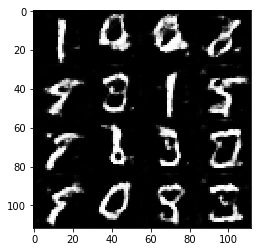

Epoch 1/2... Discriminator Loss: 1.252744... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 1.414196... Generator Loss: 0.5805
Epoch 1/2... Discriminator Loss: 1.405276... Generator Loss: 0.5137
Epoch 1/2... Discriminator Loss: 1.231420... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.575466... Generator Loss: 0.3980
Epoch 1/2... Discriminator Loss: 1.348831... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 1.351381... Generator Loss: 0.6499
Epoch 1/2... Discriminator Loss: 1.264947... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.603507... Generator Loss: 1.6579
Epoch 1/2... Discriminator Loss: 1.384231... Generator Loss: 0.9805


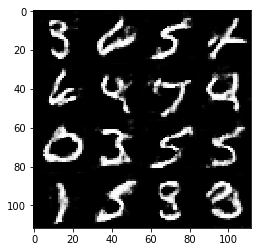

Epoch 1/2... Discriminator Loss: 1.383277... Generator Loss: 1.4076
Epoch 1/2... Discriminator Loss: 1.310616... Generator Loss: 0.8114
Epoch 1/2... Discriminator Loss: 1.276989... Generator Loss: 1.2118
Epoch 2/2... Discriminator Loss: 1.288046... Generator Loss: 1.0040
Epoch 2/2... Discriminator Loss: 1.332994... Generator Loss: 0.7707
Epoch 2/2... Discriminator Loss: 1.372065... Generator Loss: 1.2862
Epoch 2/2... Discriminator Loss: 1.299917... Generator Loss: 1.1369
Epoch 2/2... Discriminator Loss: 1.318323... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 1.558647... Generator Loss: 1.6221
Epoch 2/2... Discriminator Loss: 1.280095... Generator Loss: 0.8387


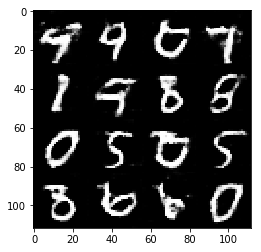

Epoch 2/2... Discriminator Loss: 1.412736... Generator Loss: 1.6107
Epoch 2/2... Discriminator Loss: 1.335895... Generator Loss: 1.1768
Epoch 2/2... Discriminator Loss: 1.400921... Generator Loss: 1.4213
Epoch 2/2... Discriminator Loss: 1.280118... Generator Loss: 1.3227
Epoch 2/2... Discriminator Loss: 1.356116... Generator Loss: 1.4150
Epoch 2/2... Discriminator Loss: 1.380142... Generator Loss: 1.1496
Epoch 2/2... Discriminator Loss: 1.345576... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 1.308596... Generator Loss: 1.1936
Epoch 2/2... Discriminator Loss: 1.837075... Generator Loss: 2.0887
Epoch 2/2... Discriminator Loss: 1.314168... Generator Loss: 0.8435


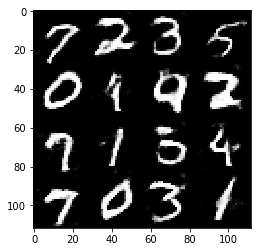

Epoch 2/2... Discriminator Loss: 1.317818... Generator Loss: 0.9799
Epoch 2/2... Discriminator Loss: 1.305033... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 1.233301... Generator Loss: 0.9114
Epoch 2/2... Discriminator Loss: 1.546436... Generator Loss: 0.4311
Epoch 2/2... Discriminator Loss: 1.518726... Generator Loss: 0.4254
Epoch 2/2... Discriminator Loss: 1.317242... Generator Loss: 0.8075
Epoch 2/2... Discriminator Loss: 1.291998... Generator Loss: 1.0341
Epoch 2/2... Discriminator Loss: 1.291055... Generator Loss: 0.9757
Epoch 2/2... Discriminator Loss: 1.238795... Generator Loss: 0.8264
Epoch 2/2... Discriminator Loss: 1.495376... Generator Loss: 0.4791


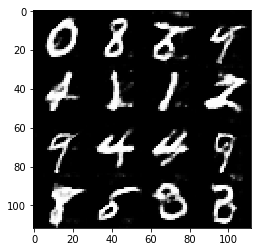

Epoch 2/2... Discriminator Loss: 1.310188... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 1.324492... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 1.281365... Generator Loss: 1.1579
Epoch 2/2... Discriminator Loss: 1.306939... Generator Loss: 0.8990
Epoch 2/2... Discriminator Loss: 1.276958... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 1.336149... Generator Loss: 1.3091
Epoch 2/2... Discriminator Loss: 1.336331... Generator Loss: 1.1866
Epoch 2/2... Discriminator Loss: 2.023841... Generator Loss: 2.1011
Epoch 2/2... Discriminator Loss: 1.264340... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 1.416567... Generator Loss: 1.2366


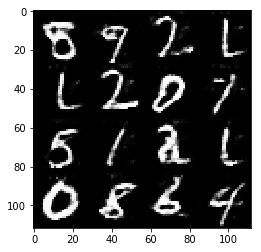

Epoch 2/2... Discriminator Loss: 1.446080... Generator Loss: 0.4933
Epoch 2/2... Discriminator Loss: 1.328853... Generator Loss: 0.5794
Epoch 2/2... Discriminator Loss: 1.331176... Generator Loss: 0.6598
Epoch 2/2... Discriminator Loss: 1.799128... Generator Loss: 0.3017
Epoch 2/2... Discriminator Loss: 1.283558... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 1.282592... Generator Loss: 0.6637
Epoch 2/2... Discriminator Loss: 1.380834... Generator Loss: 0.5841
Epoch 2/2... Discriminator Loss: 1.232646... Generator Loss: 0.7644
Epoch 2/2... Discriminator Loss: 1.391755... Generator Loss: 0.5219
Epoch 2/2... Discriminator Loss: 1.350205... Generator Loss: 0.6211


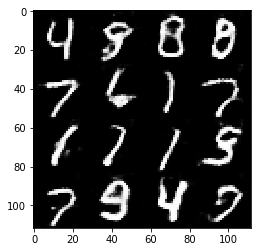

Epoch 2/2... Discriminator Loss: 1.446918... Generator Loss: 0.5297
Epoch 2/2... Discriminator Loss: 1.253426... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 1.347640... Generator Loss: 1.3708
Epoch 2/2... Discriminator Loss: 1.247624... Generator Loss: 1.0528
Epoch 2/2... Discriminator Loss: 1.257390... Generator Loss: 0.9933
Epoch 2/2... Discriminator Loss: 1.282903... Generator Loss: 1.2719
Epoch 2/2... Discriminator Loss: 1.358780... Generator Loss: 0.9539
Epoch 2/2... Discriminator Loss: 1.368661... Generator Loss: 0.6058
Epoch 2/2... Discriminator Loss: 1.383402... Generator Loss: 1.4203
Epoch 2/2... Discriminator Loss: 1.283535... Generator Loss: 1.2107


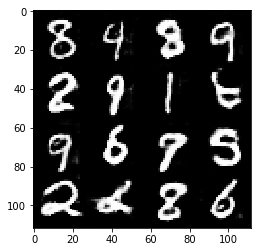

Epoch 2/2... Discriminator Loss: 1.303467... Generator Loss: 1.0686
Epoch 2/2... Discriminator Loss: 1.293536... Generator Loss: 0.9508
Epoch 2/2... Discriminator Loss: 1.236749... Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.515626... Generator Loss: 0.4398
Epoch 2/2... Discriminator Loss: 1.377187... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.277138... Generator Loss: 0.6886
Epoch 2/2... Discriminator Loss: 1.308000... Generator Loss: 0.6418
Epoch 2/2... Discriminator Loss: 1.371781... Generator Loss: 0.5456
Epoch 2/2... Discriminator Loss: 1.506175... Generator Loss: 0.4564
Epoch 2/2... Discriminator Loss: 1.284392... Generator Loss: 0.6589


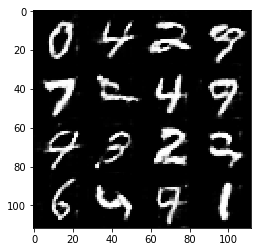

Epoch 2/2... Discriminator Loss: 1.351734... Generator Loss: 0.5495
Epoch 2/2... Discriminator Loss: 1.254699... Generator Loss: 0.7414
Epoch 2/2... Discriminator Loss: 1.499502... Generator Loss: 0.5292
Epoch 2/2... Discriminator Loss: 1.381038... Generator Loss: 0.9447
Epoch 2/2... Discriminator Loss: 1.475136... Generator Loss: 1.3475
Epoch 2/2... Discriminator Loss: 1.315062... Generator Loss: 1.2264
Epoch 2/2... Discriminator Loss: 1.355984... Generator Loss: 0.8869
Epoch 2/2... Discriminator Loss: 1.247881... Generator Loss: 1.1115
Epoch 2/2... Discriminator Loss: 1.325732... Generator Loss: 0.9598
Epoch 2/2... Discriminator Loss: 1.324971... Generator Loss: 0.8301


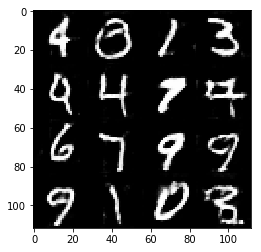

Epoch 2/2... Discriminator Loss: 1.286458... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 1.393165... Generator Loss: 0.5444
Epoch 2/2... Discriminator Loss: 1.236340... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 1.321458... Generator Loss: 1.2149
Epoch 2/2... Discriminator Loss: 1.300956... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 1.357758... Generator Loss: 1.2244
Epoch 2/2... Discriminator Loss: 1.364636... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.541662... Generator Loss: 0.4212
Epoch 2/2... Discriminator Loss: 1.288519... Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 1.358372... Generator Loss: 0.5640


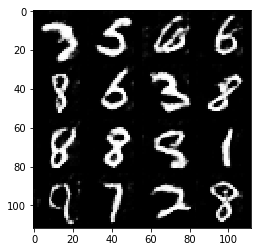

Epoch 2/2... Discriminator Loss: 1.317801... Generator Loss: 1.3738
Epoch 2/2... Discriminator Loss: 1.387718... Generator Loss: 1.4038
Epoch 2/2... Discriminator Loss: 1.318877... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 1.217782... Generator Loss: 1.2627
Epoch 2/2... Discriminator Loss: 1.356892... Generator Loss: 0.9478
Epoch 2/2... Discriminator Loss: 1.340471... Generator Loss: 1.0655
Epoch 2/2... Discriminator Loss: 1.292716... Generator Loss: 1.0636


In [75]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.642886... Generator Loss: 0.1198
Epoch 1/1... Discriminator Loss: 4.095248... Generator Loss: 0.2970
Epoch 1/1... Discriminator Loss: 2.159797... Generator Loss: 0.2648
Epoch 1/1... Discriminator Loss: 2.246300... Generator Loss: 0.2063
Epoch 1/1... Discriminator Loss: 1.572786... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.375189... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.589292... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.563888... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.594789... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.541447... Generator Loss: 0.6911


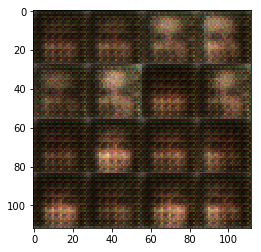

Epoch 1/1... Discriminator Loss: 1.562086... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.348451... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.550806... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.419403... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.509592... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.657570... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.606283... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 1.521008... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.383014... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.376569... Generator Loss: 0.6924


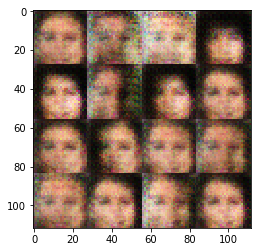

Epoch 1/1... Discriminator Loss: 1.559613... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.344201... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.438748... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.363452... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.451645... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.460961... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 1.394386... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.655440... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.374646... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.605768... Generator Loss: 1.0107


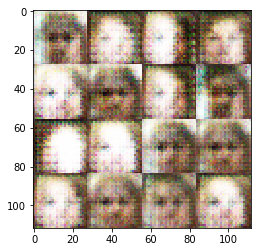

Epoch 1/1... Discriminator Loss: 1.474622... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.469671... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.588092... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.464187... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.383239... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.374864... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.449308... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.508631... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.353098... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 1.359406... Generator Loss: 0.6246


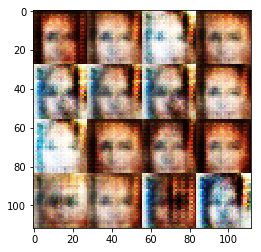

Epoch 1/1... Discriminator Loss: 1.508826... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.293060... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.462244... Generator Loss: 0.5006
Epoch 1/1... Discriminator Loss: 1.385915... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 2.012732... Generator Loss: 2.0386
Epoch 1/1... Discriminator Loss: 1.395007... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.364901... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 1.357787... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.629017... Generator Loss: 1.6823
Epoch 1/1... Discriminator Loss: 1.356447... Generator Loss: 1.2816


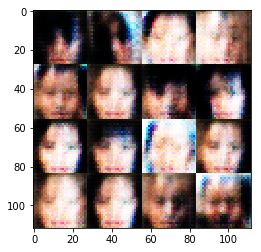

Epoch 1/1... Discriminator Loss: 1.932770... Generator Loss: 1.1584
Epoch 1/1... Discriminator Loss: 1.397299... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.327391... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.823980... Generator Loss: 0.2767
Epoch 1/1... Discriminator Loss: 1.496688... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.310455... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.273851... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.502798... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.295356... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.397103... Generator Loss: 0.7457


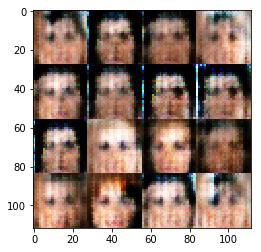

Epoch 1/1... Discriminator Loss: 1.453252... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.258991... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.381430... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.454248... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.136746... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.567952... Generator Loss: 1.3413
Epoch 1/1... Discriminator Loss: 1.257770... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 1.381709... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.422089... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.367686... Generator Loss: 0.8229


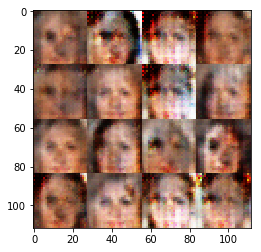

Epoch 1/1... Discriminator Loss: 1.541208... Generator Loss: 1.6525
Epoch 1/1... Discriminator Loss: 1.376659... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.365520... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 1.373547... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.453053... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 1.452590... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.347550... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.430026... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.417474... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.532770... Generator Loss: 1.0896


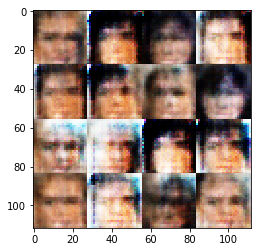

Epoch 1/1... Discriminator Loss: 1.352074... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.442518... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.354635... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.367737... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.426544... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.411833... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.782594... Generator Loss: 1.7001
Epoch 1/1... Discriminator Loss: 1.368611... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.385087... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.520421... Generator Loss: 1.2677


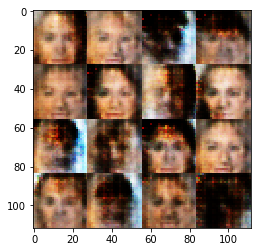

Epoch 1/1... Discriminator Loss: 1.382747... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.282646... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.728733... Generator Loss: 1.5945
Epoch 1/1... Discriminator Loss: 1.312839... Generator Loss: 1.1967
Epoch 1/1... Discriminator Loss: 1.489441... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.461369... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.373002... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.418809... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.444609... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.332503... Generator Loss: 0.7850


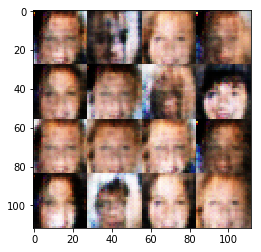

Epoch 1/1... Discriminator Loss: 1.413284... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.359104... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.356227... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.668176... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 1.388016... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.348375... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.428168... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.419117... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.341296... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.308562... Generator Loss: 0.7407


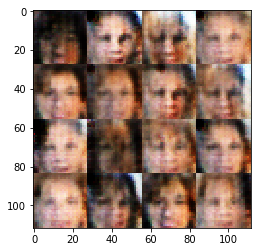

Epoch 1/1... Discriminator Loss: 1.391071... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.431833... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.402417... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.478056... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.409468... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.251819... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.342052... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.347348... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.381603... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.409939... Generator Loss: 1.3235


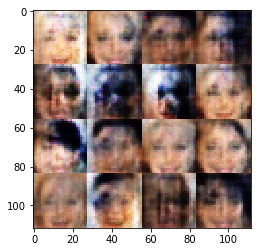

Epoch 1/1... Discriminator Loss: 1.371592... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.385981... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.373891... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.368762... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.399390... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.421816... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.365198... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.393651... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.403844... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.372128... Generator Loss: 0.7825


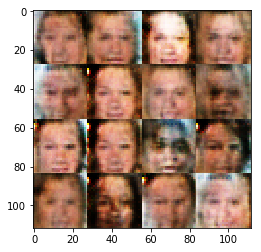

Epoch 1/1... Discriminator Loss: 1.372160... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.369812... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.340364... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.442527... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.346947... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.366432... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.345583... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.377442... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.432114... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.441317... Generator Loss: 0.6117


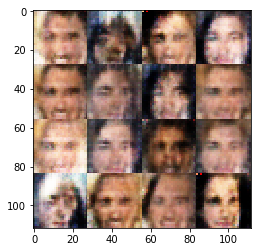

Epoch 1/1... Discriminator Loss: 1.380008... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.450399... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.408143... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.394996... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.492477... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.481605... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.467171... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.388931... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.475784... Generator Loss: 1.3595
Epoch 1/1... Discriminator Loss: 1.371412... Generator Loss: 0.9673


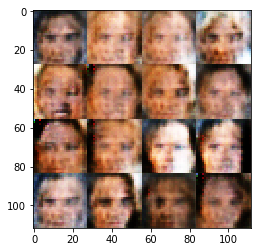

Epoch 1/1... Discriminator Loss: 1.360549... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.467487... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.437773... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.441533... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.357022... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.415875... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.451170... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.378604... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.471649... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.359582... Generator Loss: 0.8251


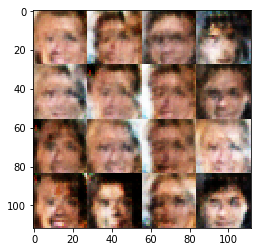

Epoch 1/1... Discriminator Loss: 1.350695... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.400609... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.352013... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.363906... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.329584... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 1.362186... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.924525... Generator Loss: 1.9508
Epoch 1/1... Discriminator Loss: 1.400615... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.411713... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.421555... Generator Loss: 0.9510


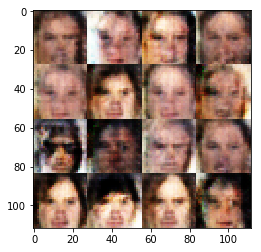

Epoch 1/1... Discriminator Loss: 1.253914... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.326894... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.361231... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.236172... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 1.380005... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 1.364252... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.484659... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.398745... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.400480... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.404914... Generator Loss: 0.9342


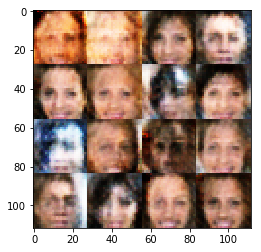

Epoch 1/1... Discriminator Loss: 1.365486... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.327875... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.409907... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.331857... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.431844... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.331270... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.481750... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 1.423053... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.435063... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.348586... Generator Loss: 0.8152


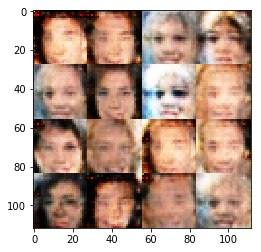

Epoch 1/1... Discriminator Loss: 1.266467... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.372909... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.337011... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.450413... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.388070... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.378674... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.562360... Generator Loss: 1.2660
Epoch 1/1... Discriminator Loss: 1.397604... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.449947... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 1.375257... Generator Loss: 0.7505


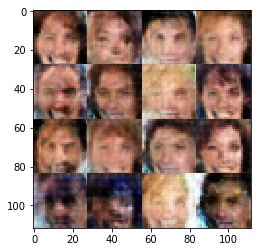

Epoch 1/1... Discriminator Loss: 1.449846... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.357634... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.390842... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.417782... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.345618... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.414695... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.420328... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.336152... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.373389... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.371654... Generator Loss: 0.8619


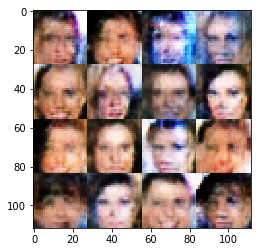

Epoch 1/1... Discriminator Loss: 1.432429... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.453271... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.483093... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.351232... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.538120... Generator Loss: 1.2936
Epoch 1/1... Discriminator Loss: 1.302556... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.323585... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.475090... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 1.358884... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.361957... Generator Loss: 0.6722


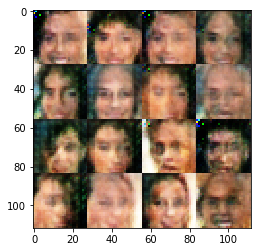

Epoch 1/1... Discriminator Loss: 1.446922... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.306850... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.442518... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.352439... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.361508... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.335629... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.343412... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.323684... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.311226... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.340251... Generator Loss: 0.8555


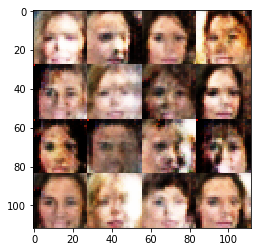

Epoch 1/1... Discriminator Loss: 1.469403... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.324602... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.398465... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.417335... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.304800... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.363669... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.438333... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.355363... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.512122... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.255165... Generator Loss: 0.8231


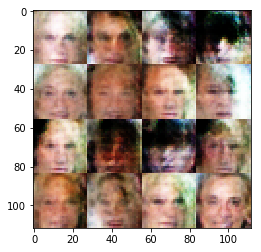

Epoch 1/1... Discriminator Loss: 1.345748... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.356114... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.290641... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.361107... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.392525... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.395404... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.409790... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.472628... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 1.399621... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.476258... Generator Loss: 0.7556


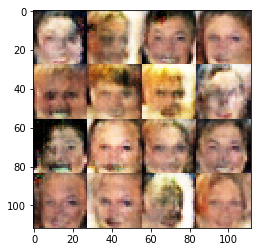

Epoch 1/1... Discriminator Loss: 1.344894... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.337374... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.348704... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.329654... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.348275... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 1.343565... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.396376... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.396932... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.384123... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.550982... Generator Loss: 0.5953


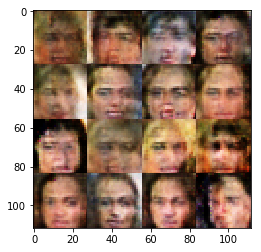

Epoch 1/1... Discriminator Loss: 1.330093... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.356890... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.335971... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.360932... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.332464... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.232665... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.287331... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.339313... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.309314... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.370766... Generator Loss: 0.9054


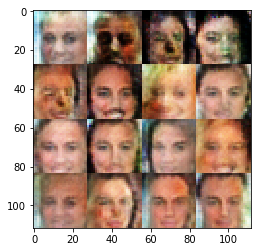

Epoch 1/1... Discriminator Loss: 1.478118... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.325230... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.335370... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.297404... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.273345... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.366413... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.253040... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.250650... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 1.310186... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.198012... Generator Loss: 1.0576


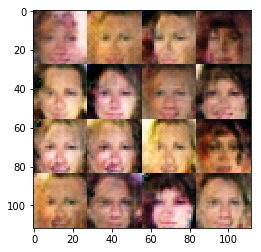

Epoch 1/1... Discriminator Loss: 1.432858... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.354684... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.286189... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.275698... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.378242... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.285111... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.337072... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.468394... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 1.271594... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.356525... Generator Loss: 0.8460


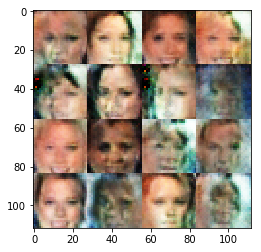

Epoch 1/1... Discriminator Loss: 1.411989... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.441583... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.361348... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.381560... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.254915... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.368870... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.357110... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.326208... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.379103... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.431341... Generator Loss: 1.2494


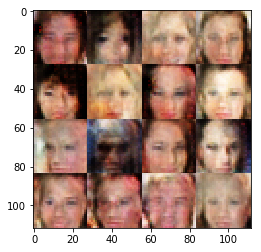

Epoch 1/1... Discriminator Loss: 1.369476... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.415320... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.386606... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.546706... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.381763... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.415391... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.377969... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.377331... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.362752... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.443092... Generator Loss: 0.5485


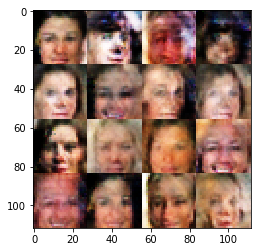

Epoch 1/1... Discriminator Loss: 1.324366... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.298218... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.446242... Generator Loss: 1.2004
Epoch 1/1... Discriminator Loss: 1.324824... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.311429... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.417719... Generator Loss: 0.6548


In [76]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.